# Create adversarial samples 

In [1]:
bucket="aegovan-data"

train_data = f"s3://{bucket}/chemprot/chemprot_abstract_train.json"
test_data = f"s3://{bucket}/chemprot/chemprot_abstract_test.json"
val_data = f"s3://{bucket}/chemprot/chemprot_abstract_val.json"



output_data = f"s3://{bucket}/chemprot_adversarial"



In [2]:

from datetime import datetime

datefmt = datetime.now().strftime("%Y%m%d%H%M")

output_data = f"{output_data}/{datefmt}"

In [3]:
import pandas as pd
import sagemaker, io

In [4]:
df = pd.read_json( io.StringIO(sagemaker.s3.S3Downloader.read_file(train_data)))
df.sample(n=3)

,abstract_id,abstract,participant1_id,participant1,participant2_id,participant2,annotations,relationship_type,relationship_group,is_eval,label
1697,15562257,State-dependent mibefradil block of Na+ channe...,T1,"{'abstract_id': '15562257', 'id': 'T1', 'entit...",T24,"{'abstract_id': '15562257', 'id': 'T24', 'enti...","[{'abstract_id': '15562257', 'id': 'T1', 'enti...",ANTAGONIST,CPR:6,Y,CPR:6
4338,23301897,Bioactive flavaglines and other constituents i...,T2,"{'abstract_id': '23301897', 'id': 'T2', 'entit...",T17,"{'abstract_id': '23301897', 'id': 'T17', 'enti...","[{'abstract_id': '23301897', 'id': 'T1', 'enti...",INHIBITOR,CPR:4,Y,CPR:4
1587,15132128,Enzyme expression profiles suggest the novel t...,T3,"{'abstract_id': '15132128', 'id': 'T3', 'entit...",T26,"{'abstract_id': '15132128', 'id': 'T26', 'enti...","[{'abstract_id': '15132128', 'id': 'T1', 'enti...",INHIBITOR,CPR:4,Y,CPR:4


<AxesSubplot:ylabel='Frequency'>

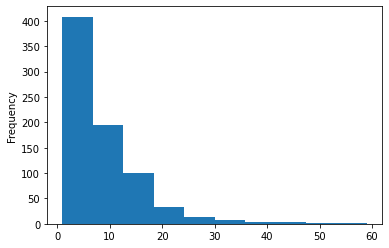

In [5]:
df.groupby(["abstract_id"]).size().plot.hist()

In [6]:
df.groupby(["abstract_id"]).size().describe()

count    767.000000
mean       8.392438
std        7.643567
min        1.000000
25%        3.000000
50%        6.000000
75%       11.000000
max       59.000000
dtype: float64

In [7]:
df.groupby(["label"]).size()

label
CPR:3        777
CPR:4       2260
CPR:5        173
CPR:6        235
CPR:9        727
NEGATIVE    2265
dtype: int64

In [8]:
df.groupby(["abstract_id", "label"]).size().describe()

count    1382.000000
mean        4.657742
std         4.838381
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        58.000000
dtype: float64

In [9]:
df.query("label == 'NEGATIVE' or label == 'CPR:4'").shape

(4525, 11)

<AxesSubplot:ylabel='Frequency'>

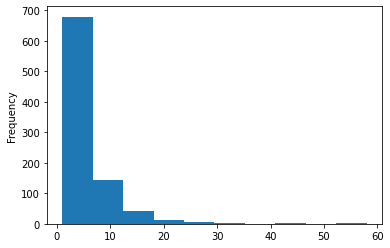

In [10]:
df.query("label == 'NEGATIVE' or label == 'CPR:4'").groupby(["abstract_id", "label"]).size().plot.hist()

<AxesSubplot:ylabel='Frequency'>

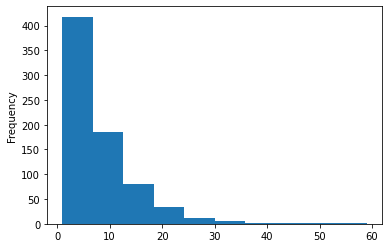

In [11]:
df.query("label != 'CPR:3'").groupby(["abstract_id"]).size().plot.hist()

In [12]:
df.query("label != 'CPR:3'").groupby(["abstract_id"]).size().describe()

count    740.000000
mean       7.648649
std        7.110252
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       59.000000
dtype: float64

In [13]:
df.query("label == 'CPR:3'").groupby(["abstract_id"]).size().describe()

count    210.000000
mean       3.700000
std        3.397227
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       20.000000
dtype: float64

In [14]:
df.query("label == 'CPR:3'").shape

(777, 11)

In [15]:
def upload_to_s3(df, s3_uri):
    json_data = io.StringIO() 
    df.to_json( json_data )


    sagemaker.s3.S3Uploader.upload_string_as_file_body(json_data.getvalue(), s3_uri)

In [16]:
def update_label(df, pos_label):
    df["label"] = df["label"].apply(lambda x: 1 if x == pos_label else 0)
    return df
    
def update_label_upload_s3(df, s3_uri_base, pos_label, filename):
    df = update_label(df, pos_label)
    
    s3_uri = "{}/{}".format( s3_uri_base.rstrip("/"), filename)
    
    upload_to_s3(df, s3_uri)

{'UniquePositives': 210, 'AllPositives': 777, 'AffablePositives': 567, 'AffablePositiveRate': 0.7297297297297297, 'UniquePositiveSampleRate': 0.03262389311791207, 'PositiveSampleRate': 0.12070840453627467, 'UniqueNegatives': 740, 'AllNegatives': 5660, 'AffableNegatives': 4920, 'AffableNegativeRate': 0.8692579505300353, 'UniqueNonAdversarialNegatives': 557, 'AllNonAdversarialNegatives': 4145, 'UniqueAdversarialNegatives': 183, 'AllAdversarialNegatives': 1515, 'AdversarialRate': 1.94980694980695, 'UniqueAdversarialRate': 0.23552123552123552, 'TotalSize': 6437, 'UniqueAbstracts': 767}
s3://aegovan-data/chemprot_adversarial/202212271345/adversarial/train_767_210_0.json {'UniquePositives': 210, 'AllPositives': 210, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.2737940026075619, 'PositiveSampleRate': 0.2737940026075619, 'UniqueNegatives': 557, 'AllNegatives': 557, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 557, 'AllN

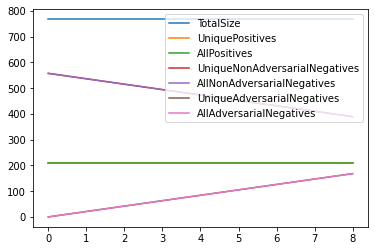

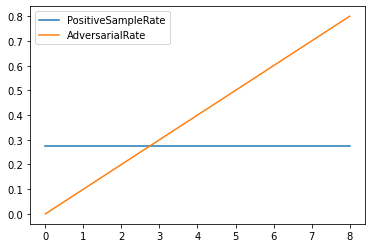

In [17]:
import numpy as np

def get_stats(df, pos_label):
    stats ={}
    
    # Positive samples
    df_positive = df.query(f"label == '{pos_label}'")
    df_positive_unique = df_positive.drop_duplicates('abstract_id')
    stats["UniquePositives"] = len(df_positive_unique)
    stats["AllPositives"] = len(df_positive)
    stats["AffablePositives"] = len(df_positive) - len(df_positive_unique)
    stats["AffablePositiveRate"] = stats["AffablePositives"]/len(df_positive)



    stats["UniquePositiveSampleRate"] = stats["UniquePositives"]/(len(df))
    stats["PositiveSampleRate"] = stats["AllPositives"]/(len(df))
    
    
    # Negative samples
    df_negative = df.query(f"label != '{pos_label}'")
    df_negative_unique = df_negative.drop_duplicates('abstract_id')


    stats["UniqueNegatives"] = len(df_negative_unique)
    stats["AllNegatives"] = len(df_negative)
    stats["AffableNegatives"] = len(df_negative) - len(df_negative_unique)
    stats["AffableNegativeRate"] = stats["AffableNegatives"]/stats["AllNegatives"] 


    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"label == '{pos_label}'")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries = df[~abstracts_id_with_positive]
    df_negative_non_adverseries_unique =df_negative_non_adverseries.drop_duplicates('abstract_id')
    stats["UniqueNonAdversarialNegatives"] = len(df_negative_non_adverseries_unique)
    stats["AllNonAdversarialNegatives"] = len(df_negative_non_adverseries)

    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries = df[abstracts_id_with_positive].query(f"label != '{pos_label}'")
    df_negative_adverseries_unique = df_negative_adverseries.drop_duplicates('abstract_id')
    stats["UniqueAdversarialNegatives"] = len(df_negative_adverseries_unique)
    stats["AllAdversarialNegatives"] = len(df_negative_adverseries)
    
    # TODO: Check if unique positive is appropriate
    stats["AdversarialRate"] = stats["AllAdversarialNegatives"]/len(df_positive)
    stats["UniqueAdversarialRate"] = stats["UniqueAdversarialNegatives"]/len(df_positive)


    stats["TotalSize"] = len(df)
    stats["UniqueAbstracts"] = df["abstract"].nunique()


    return stats


def mixmatch_training_data_discriminatory(df, discriminitory_rate, pos_label):
    
    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"label == '{pos_label}'").drop_duplicates('abstract_id')
    df_positive_unique_sim = df.query(f"label == '{pos_label}'")
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"label == '{pos_label}'")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')
    
    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries_unique = df[abstracts_id_with_positive].query(f"label != '{pos_label}'").drop_duplicates('abstract_id')
    
    df_negative_adverseries_simi = df[abstracts_id_with_positive].query(f"label != '{pos_label}'")
    
    
    discriminitory_size = int(len(df_positive_unique)  * discriminitory_rate)
    if discriminitory_size > 0:
        drop_indices = np.random.choice(df_negative_non_adverseries_unique.index, discriminitory_size, replace=False)
      
        df_negative_non_adverseries_unique = df_negative_non_adverseries_unique.drop(drop_indices).copy()
        
        df_negative_adverseries_unique = df_negative_adverseries_unique.sample(n=discriminitory_size).copy()
        
        df_negative_adverseries_unique["label"] = 'NEGATIVE'
        df_negative_non_adverseries_unique["label"] =  'NEGATIVE'
    else:
        # Empty adversarial unique
        df_negative_adverseries_unique = pd.DataFrame()
     
    
    final_data = pd.concat([df_positive_unique, 
                            df_negative_non_adverseries_unique, 
                            df_negative_adverseries_unique]).reset_index()
    
    final_data["label"] = final_data["label"].apply(lambda x: 1 if x == pos_label else 0)
    return final_data



def create_discriminatory_samples_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    for i in range(0, 9):

        df_train_data = mixmatch_training_data_discriminatory(df, discriminitory_rate=i/10, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        
        s3_uri = "{}/adversarial/{}".format( s3_uri_base.rstrip("/"), f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["UniqueAdversarialNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_to_s3(df_train_data, s3_uri)
        

    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate"]].plot.line()
    







print(get_stats(df, "CPR:3"))
create_discriminatory_samples_and_upload_to_s3(df, output_data,  "CPR:3")



s3://aegovan-data/chemprot_adversarial/202212271345/affablenegatives/train_767_210_0.json {'UniquePositives': 210, 'AllPositives': 210, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.2737940026075619, 'PositiveSampleRate': 0.2737940026075619, 'UniqueNegatives': 557, 'AllNegatives': 557, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 557, 'AllNonAdversarialNegatives': 557, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 767, 'UniqueAbstracts': 767}
s3://aegovan-data/chemprot_adversarial/202212271345/affablenegatives/train_767_210_55.json {'UniquePositives': 210, 'AllPositives': 210, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.2737940026075619, 'PositiveSampleRate': 0.2737940026075619, 'UniqueNegatives': 502, 'AllNegatives': 557, 'AffableNegatives': 55, 'AffableNegativeRate': 0.09874326750448834, 'Uni

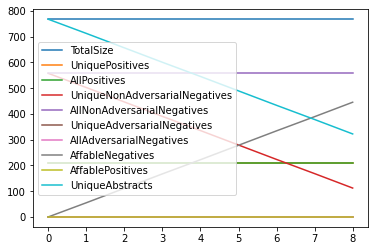

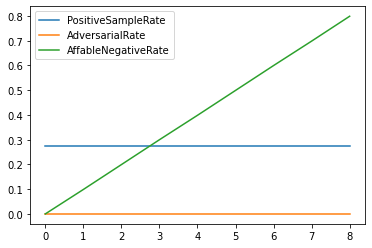

In [18]:
def mixmatch_training_data_affable_negatives(df, affability_rate, pos_label):
    
    assert df.index.nunique() == len(df), "Expect unique indices"
    
    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"label == '{pos_label}'").drop_duplicates('abstract_id')
    df_positive_unique_all = df.query(f"label == '{pos_label}'")
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"label == '{pos_label}'")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')
    
    df_negative_non_adverseries_all = df[~abstracts_id_with_positive]
    
    
    df_negative_non_adverseries_affable = pd.DataFrame()
    
    affability_size = int(len(df_negative_non_adverseries_unique)  * affability_rate)
    if affability_rate > 0:
        drop_indices = np.random.choice(df_negative_non_adverseries_unique.index, affability_size, replace=False)
      
        df_negative_non_adverseries_unique = df_negative_non_adverseries_unique.drop(drop_indices).copy()
        
        # Remove the ones that are in non-unique, i.e. affable
        df_negative_non_adverseries_affable_all = df_negative_non_adverseries_all[~df_negative_non_adverseries_all.index.isin(df_negative_non_adverseries_unique.index)]
        df_negative_non_adverseries_affable = df_negative_non_adverseries_affable_all[df_negative_non_adverseries_affable_all["abstract_id"]\
                                                                              .isin(df_negative_non_adverseries_unique["abstract_id"]
                                                                                   
                                                                                   )]


        
        df_negative_non_adverseries_affable = df_negative_non_adverseries_affable.sample(n=affability_size).copy()
        
        df_negative_non_adverseries_unique["label"] = 'NEGATIVE'
        df_negative_non_adverseries_affable["label"] =  'NEGATIVE'
    else:
        # Empty adversarial unique
        df_negative_adverseries_unique = pd.DataFrame()
     
    
    final_data = pd.concat([df_positive_unique, 
                            df_negative_non_adverseries_unique, 
                            df_negative_non_adverseries_affable]).reset_index()
    
    final_data["label"] = final_data["label"].apply(lambda x: 1 if x == pos_label else 0)
    return final_data


def create_affable_negatives_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    for i in range(0, 9):

        df_train_data = mixmatch_training_data_affable_negatives(df, affability_rate=i/10, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
      
        
        s3_uri = "{}/affablenegatives/{}".format( s3_uri_base.rstrip("/"), f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["AffableNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_to_s3(df_train_data, s3_uri)
        

    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives", "AffableNegatives", "AffablePositives"
                       ,"UniqueAbstracts" ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate", "AffableNegativeRate"]].plot.line()
    
create_affable_negatives_and_upload_to_s3(df, output_data,  "CPR:3")



s3://aegovan-data/chemprot_adversarial/202212271345/affablepositives/train_767_210_0.json {'UniquePositives': 210, 'AllPositives': 210, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.2737940026075619, 'PositiveSampleRate': 0.2737940026075619, 'UniqueNegatives': 557, 'AllNegatives': 557, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 557, 'AllNonAdversarialNegatives': 557, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 767, 'UniqueAbstracts': 767}
s3://aegovan-data/chemprot_adversarial/202212271345/affablepositives/train_767_210_21.json {'UniquePositives': 189, 'AllPositives': 210, 'AffablePositives': 21, 'AffablePositiveRate': 0.1, 'UniquePositiveSampleRate': 0.24641460234680573, 'PositiveSampleRate': 0.2737940026075619, 'UniqueNegatives': 557, 'AllNegatives': 557, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversari

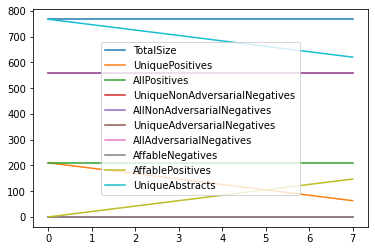

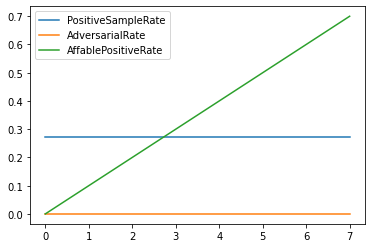

In [19]:
def mixmatch_training_data_affable_positives(df, affability_rate, pos_label):
    
    assert df.index.nunique() == len(df), "Expect unique indices"
    
    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"label == '{pos_label}'").drop_duplicates('abstract_id')
    df_positive_unique_all = df.query(f"label == '{pos_label}'")
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"label == '{pos_label}'")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')
    
    df_negative_non_adverseries_all = df[~abstracts_id_with_positive]
    
    
    df_negative_non_adverseries_affable = pd.DataFrame()
    
    affability_size = int(len(df_positive_unique)  * affability_rate)
    if affability_rate > 0:
        drop_indices = np.random.choice(df_positive_unique.index, affability_size, replace=False)
      
        df_positive_unique = df_positive_unique.drop(drop_indices).copy()
        
        # Remove the ones that are in non-unique, i.e. affable
        df_positive_affable_not_in_unique = df_positive_unique_all[~df_positive_unique_all.index.isin(df_positive_unique.index)]
        df_positive_affable = df_positive_affable_not_in_unique[df_positive_affable_not_in_unique["abstract_id"]\
                                                                              .isin(df_positive_unique["abstract_id"]
                                                                                   
                                                                                   )]


        
        df_positive_affable = df_positive_affable.sample(n=affability_size).copy()
        
       
    else:
        # Empty adversarial unique
        df_positive_affable = pd.DataFrame()
     
    
    final_data = pd.concat([df_positive_unique, 
                            df_negative_non_adverseries_unique, 
                            df_positive_affable]).reset_index()
    
    final_data = final_data.pipe( update_label, pos_label)
    return final_data


def create_affable_positives_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    for i in range(0, 8):

        df_train_data = mixmatch_training_data_affable_positives(df, affability_rate=i/10, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/affablepositives/{}".format( s3_uri_base.rstrip("/"), f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["AffablePositives"]}.json')
        print(s3_uri, stat )
        
        upload_to_s3(df_train_data, s3_uri)

        

    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives", "AffableNegatives", "AffablePositives"
                       ,"UniqueAbstracts" ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate", "AffablePositiveRate"]].plot.line()
    



create_affable_positives_and_upload_to_s3(df, output_data,  "CPR:3")



In [20]:
pd.read_json( io.StringIO(sagemaker.s3.S3Downloader.read_file(test_data))).head()

,abstract_id,abstract,participant1_id,participant1,participant2_id,participant2,annotations,relationship_type,relationship_group,is_eval,label
0,10076535,Androgen antagonistic effect of estramustine p...,T23,"{'abstract_id': '10076535', 'id': 'T23', 'enti...",T55,"{'abstract_id': '10076535', 'id': 'T55', 'enti...","[{'abstract_id': '10076535', 'id': 'T10', 'ent...",DIRECT-REGULATOR,CPR:2,N,NEGATIVE
1,10076535,Androgen antagonistic effect of estramustine p...,T2,"{'abstract_id': '10076535', 'id': 'T2', 'entit...",T48,"{'abstract_id': '10076535', 'id': 'T48', 'enti...","[{'abstract_id': '10076535', 'id': 'T10', 'ent...",DIRECT-REGULATOR,CPR:2,N,NEGATIVE
2,10076535,Androgen antagonistic effect of estramustine p...,T3,"{'abstract_id': '10076535', 'id': 'T3', 'entit...",T48,"{'abstract_id': '10076535', 'id': 'T48', 'enti...","[{'abstract_id': '10076535', 'id': 'T10', 'ent...",DIRECT-REGULATOR,CPR:2,N,NEGATIVE
3,10076535,Androgen antagonistic effect of estramustine p...,T4,"{'abstract_id': '10076535', 'id': 'T4', 'entit...",T48,"{'abstract_id': '10076535', 'id': 'T48', 'enti...","[{'abstract_id': '10076535', 'id': 'T10', 'ent...",DIRECT-REGULATOR,CPR:2,N,NEGATIVE
4,10076535,Androgen antagonistic effect of estramustine p...,T23,"{'abstract_id': '10076535', 'id': 'T23', 'enti...",T56,"{'abstract_id': '10076535', 'id': 'T56', 'enti...","[{'abstract_id': '10076535', 'id': 'T10', 'ent...",INDIRECT-UPREGULATOR,CPR:3,Y,CPR:3


In [21]:
update_label(pd.read_json( io.StringIO(sagemaker.s3.S3Downloader.read_file(test_data)))
            , "CPR:3"
            )["label"].value_counts()

0    5077
1     667
Name: label, dtype: int64

In [22]:
update_label(pd.read_json( io.StringIO(sagemaker.s3.S3Downloader.read_file(val_data)))
            , "CPR:3"
            )["label"].value_counts()

0    3006
1     552
Name: label, dtype: int64

In [23]:
update_label_upload_s3( pd.read_json( io.StringIO(sagemaker.s3.S3Downloader.read_file(test_data))),output_data, "CPR:3", test_data.split("/")[-1])
update_label_upload_s3( pd.read_json( io.StringIO(sagemaker.s3.S3Downloader.read_file(val_data))), output_data, "CPR:3", val_data.split("/")[-1] )



 Start with random base sample pos = 1000
  drate = 0
= 1000 p + 2000 negative [3000, drate 0, 33% positive rate]

= 1000 p + 1700 + 300 derived             [3000, .10, 33% positive rate]

= 1000 p + 1400 + 600 dervied   [3000, .20, 33% positive rate]

= 1000 p + 1100 + 900 dervied   [3000, .30, 33% positive rate]

= 1000 p + 800 + 1200 dervied ,  [ .40]

= 1000 p + 500 + 1500, dervied ,  [ .50]

= 1000 p +  0 + 2000 dervied ,  [ 1]

= 



Discrimintory strength rate for label p = derived samples  that change base label p / base labels for p

similarity rate  = derived samples that do not change the label / total sample = 0
